# here we use foolbox to generate DNNs attacks

- [foolbox](https://github.com/bethgelab/foolbox)
- [DNN attack - Decoupling Direction and Norm for Efficient Gradient-Based L2 Adversarial Attacks and Defenses ](https://arxiv.org/abs/1811.09600)

The idea of this attack is that it let us select the target category, and is better in terms of L2 norm compared to the Carlini and Wagner attack and is faster.

In [1]:
%load_ext autoreload
%autoreload 2

In [138]:
import sys
sys.path.append('../code/')
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from PIL import Image

import utils
from data_loading import ImageSequence

from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
tf.get_logger().setLevel('INFO')

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load samples

In [6]:
dataset_path = '/data/datasets/imagenet2012/'

In [7]:
train_generator = ImageSequence(dataset_path, 80, target_split='train', square_ims='center_pad', augment=True)
class_desc_mapper = train_generator.generate_classes_and_desc()

  1%|          | 12/1001 [00:00<00:08, 118.37it/s]

generating splits


100%|██████████| 1001/1001 [00:09<00:00, 105.74it/s]


In [9]:
new_model = keras.models.load_model('./resnet_1001_10_iters.hdf5')

In [12]:
proc_s = train_generator.load_im_and_proc(s[1])
targets_path = ['/home/ivan/Dropbox/scratch/brad_targets/brad_fight_1.jpg', 
                '/home/ivan/Dropbox/scratch/brad_targets/brad_ah.jpeg', 
                '/home/ivan/Dropbox/scratch/brad_targets/b_h.jpeg']

In [29]:
ims_orig = np.array([np.array(utils.center_crop_square(x)) for x in targets_path])
ims_proc = preprocess_input(ims_orig) #[utils.square_pad_image(x) for x in ims_orig]
for im in ims_orig:
    plt.figure()
    plt.imshow(im)

In [35]:
pp = new_model.predict(ims_proc)
np.argmax(pp, axis=1), np.max(pp, axis=1)

(array([1000, 1000, 1000]),
 array([0.93546   , 0.99880314, 0.9998629 ], dtype=float32))

In [36]:
# plt.figure(figsize=(2,2))
# plt.imshow(im_ar)
# plt.figure(figsize=(2,2))
# plt.imshow(im_ar_proc_single)
# plt.figure(figsize=(2,2))
# plt.imshow(utils.depreprocess(im_ar_proc_single)/255)

### foolbox implementation

https://foolbox.readthedocs.io/en/stable/index.html

In [41]:
import foolbox as fb
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples, Model
from foolbox.attacks import LinfPGD
import foolbox.attacks as fa
from tensorflow.keras.applications.resnet50 import preprocess_input

In [47]:
# im_arr_orig = np.expand_dims(utils.square_pad_image(im_ar).astype('float32'), axis=0)
# im_arr_tf = tf.convert_to_tensor(im_arr_orig)
im_arr_tf = tf.convert_to_tensor(ims_orig.astype('float32'))
im_tensor = ep.astensor(im_arr_tf)
labels_tensor = ep.astensor(tf.convert_to_tensor(np.array([1000] * im_arr_tf.shape[0])))
print(im_tensor.shape, labels_tensor.shape)

(3, 224, 224, 3) (3,)


In [44]:
pre = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])  # RGB to BGR
fmodel: Model = TensorFlowModel(new_model, bounds=(0, 255), preprocessing=pre)
# this is in case the input images are in the interval 0..1
# fmodel = fmodel.transform_bounds((0, 1)) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [45]:
# xx, restore_type = ep.astensor_(im_arr_tf)
# y = fmodel._preprocess(xx)
# z = ep.astensor(fmodel._model(y.raw))
# zz = restore_type(z)
# zz

In [48]:
accuracy(fmodel, im_tensor, labels_tensor)

1.0

### Run targetted attack

In [50]:
pre = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])  # RGB to BGR
fmodel: Model = TensorFlowModel(new_model, bounds=(0, 255), preprocessing=pre)
fmodel = fmodel.transform_bounds((0, 1)) 

In [70]:
# n_attemps = 1
# im_arr_orig = [utils.square_pad_image(ims_orig[0]).astype('float32') for i in range(n_attemps)]
im_arr_orig = ims_orig.astype('float32').copy()
im_arr_tf = tf.convert_to_tensor(im_arr_orig)
im_tensor = ep.astensor(im_arr_tf)
im_tensor_01 = im_tensor/255
# labels_tensor = ep.astensor(tf.convert_to_tensor(np.array([1000 for i in range(n_attemps)])))
# target_classes = tf.convert_to_tensor(np.random.choice(np.arange(1000), n_attemps))

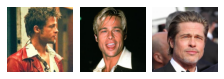

In [71]:
fb.plot.images(im_tensor_01)
# fb.plot.images(advs)
# fb.plot.images(advs - im_tensor_01, n=n_attemps, bounds=(-0.1, 0.1), scale=4.)

### Test DNN attack
- L2DeepFoolAttack
- DDNAttack

In [150]:
epsilons = [0.0, 0.1, 0.3, 1.0, 2.0, 8.0, 10., 20., 50, 255]
tcls = [29, 107, 106, 963, 937, 801, 684, 631, 614, 530, 445, 355, 338,]
results = []
for tc in tqdm(tcls):
    target_classes = tf.convert_to_tensor(np.array([tc] * im_tensor_01.shape[0]))
    criterion = fb.criteria.TargetedMisclassification(target_classes)
    attack = fb.attacks.DDNAttack(steps=1000)
    advs, clipped_advs, is_adv = attack(fmodel, im_tensor_01, criterion, epsilons=epsilons)
    results.append([advs, clipped_advs, is_adv])

In [154]:
eps_val = 4
for i, r in enumerate(results):
    ind = '{}_{}'.format(i, eps_val)
    print(ind)
    aa = fmodel(r[1][eps_val])
    print(np.argmax(aa.numpy(), axis=1))
    print(np.max(aa.numpy(), axis=1))    
    for im_num in range(3):
        im = Image.fromarray((r[1][eps_val].numpy()[im_num]*255).astype('uint8'))
        im.save('./nbpit_ims/{}_{}_{}_nbp.jpg'.format(i, eps_val, im_num))
#     fb.plot.images(r[1][eps_val])
#     plt.show()
    print('___')

0_4
[29 29 29]
[0.23577891 0.46095747 0.9681482 ]
___
1_4
[107 107 107]
[0.4250617  0.419757   0.99747014]
___
2_4
[106 106 106]
[0.17054167 0.43750098 0.45611927]
___
3_4
[963 963 963]
[0.15256608 0.34955356 0.40427357]
___
4_4
[937 937 937]
[0.12898152 0.31402948 0.40329683]
___
5_4
[801 801 801]
[0.19347918 0.28919265 0.43218517]
___
6_4
[684 684 684]
[0.18803078 0.39873812 0.5291003 ]
___
7_4
[631 631 631]
[0.23251542 0.35154554 0.304807  ]
___
8_4
[614 614 614]
[0.29903182 0.289989   0.36111766]
___
9_4
[530 530 530]
[0.3416138  0.42100593 0.34739193]
___
10_4
[445 445 445]
[0.2670636 0.2725246 0.3369817]
___
11_4
[355 355 355]
[0.20161335 0.32736295 0.49714842]
___
12_4
[338 338 338]
[0.15238634 0.34249482 0.2959704 ]
___


In [257]:
class_desc_mapper

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

- 29: 'axolotl',
- 107: 'jellyfish',
- 106: 'wombat',
- 963: 'pizza',
- 937: 'broccoli',
- 801: 'snorkel',
- 684: 'ocarina',
- 631: 'lotion',
- 614: 'kimono',
- 530: 'digital_clock',
- 445: 'bikini',
- 355: 'llama',
- 338: 'guinea_pig',


In [63]:
[29, 107, 106, 963, 937, 801, 684, 631, 614, 530, 445, 355, 338,]

[29, 107, 106, 963, 937, 801, 684, 631, 614, 530, 445, 355, 338]

## Create ims

In [179]:
from PIL import Image, ImageDraw, ImageFont

In [209]:
os.makedirs('./nbp_advs')

In [223]:
W, H = (400,400)
font = ImageFont.truetype(
    '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 
    size=13)
eps_val = 4

counter = 1
for i, r in tqdm(enumerate(results)):
    ind = '{}_{}'.format(i, eps_val)
#     print(ind)
    aa = fmodel(r[1][eps_val])
    probs_argmax = np.argmax(aa.numpy(), axis=1)
    probs_max = np.max(aa.numpy(), axis=1)
#     print()
#     print()    
    for im_num in range(3):
        im = Image.fromarray((r[1][eps_val].numpy()[im_num]*255).astype('uint8'))
#         im.save('./nbp_advs/{}_{}_{}_nbp.jpg'.format(i, eps_val, im_num))

        label = (class_desc_mapper[tcls[i]]).replace('_', ' ')
        prob = '{:.1f}'.format(probs_max[im_num]*100)
        canvas = Image.new("RGB",(W,H),"white")
        canvas.paste(im, (int((400-227)/2), 55))
        draw = ImageDraw.Draw(canvas)

        text1 = 'Not Brad Pitt #{}:'.format(counter)
        text2 = '{}% {}'.format(prob, label)
        t1w, t1h = draw.textsize(text1, font=font)
        t2w, t2h = draw.textsize(text2, font=font)

        draw.text(((W-t1w)/2,320), text1, fill='black', font=font)
        draw.text(((W-t2w)/2,320 + t1h + 5), text2, fill='black', font=font)
        canvas.save('./nbp_advs/{}_{}_{}_nbp.jpg'.format(i, eps_val, im_num), quality=95)
#         canvas.save('/home/ivan/Dropbox/scratch/brad_adv/test.jpg', quality=95)
        counter += 1
#     print('___')



13it [00:00, 13.28it/s]
